In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from IPython.display import clear_output


In [2]:
# Загружаем набор данных CIFAR-100
(train_images, _), (_, _) = tf.keras.datasets.cifar100.load_data()

# Преобразуем изображения к диапазону [-1, 1] и меняем форму
train_images = train_images.astype('float32')
train_images = (train_images - 127.5) / 127.5  # Масштабируем изображения в диапазон [-1, 1]

BUFFER_SIZE = 50000  # Размер буфера для случайной выборки данных (CIFAR-100 имеет 50000 изображений для обучения)
BATCH_SIZE = 256  # Размер батча для обучения

# Создаём объект tf.data.Dataset для оптимального чтения и управления данными
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


In [3]:
def make_generator_model():
    model = tf.keras.Sequential()

    model.add(layers.Dense(4*4*512, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Reshape((4, 4, 512)))
    assert model.output_shape == (None, 4, 4, 512)

    # Первый слой Conv2DTranspose
    model.add(layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    # Второй слой Conv2DTranspose
    model.add(layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    # Третий слой Conv2DTranspose
    model.add(layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    # Выходной слой
    model.add(layers.Conv2DTranspose(3, kernel_size=3, strides=1, padding='same', use_bias=False, activation='tanh'))

    return model

generator = make_generator_model()
generator.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8192)              819200    
                                                                 
 batch_normalization (BatchN  (None, 8192)             32768     
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 8192)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 256)        2097152   
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 256)        1

In [4]:
def make_discriminator_model():
    model = tf.keras.Sequential()

    model.add(layers.Conv2D(64, kernel_size=3, strides=2, padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, kernel_size=3, strides=2, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

discriminator = make_discriminator_model()
discriminator.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 64)        0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)        

In [5]:
# Функции потерь с использованием hinge loss

def discriminator_loss(real_output, fake_output):
    real_loss = tf.reduce_mean(tf.nn.relu(1.0 - real_output))
    fake_loss = tf.reduce_mean(tf.nn.relu(1.0 + fake_output))
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return -tf.reduce_mean(fake_output)

# Оптимизаторы с настроенными гиперпараметрами
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.0, beta_2=0.9)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.0, beta_2=0.9)


In [14]:
EPOCHS = 50  # Увеличено количество эпох для более качественного обучения
NOISE_DIM = 100  # Размер случайного вектора шума
NUM_EXAMPLES_TO_GENERATE = 16  # Количество примеров для визуализации

# Фиксированный набор шума для визуализации прогресса
seed = tf.random.normal([NUM_EXAMPLES_TO_GENERATE, NOISE_DIM])

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    # Градиенты для генератора и дискриминатора
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [15]:
def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            train_step(image_batch)

        # Визуализация результатов после каждой эпохи
        clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)
        print(f'Epoch {epoch+1} completed')


In [16]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow((predictions[i].numpy() * 127.5 + 127.5).astype('uint8'))  # Преобразуем в диапазон [0, 255]
        plt.axis('off')

    plt.savefig(f'image_at_epoch_{epoch:04d}.png')
    plt.show()


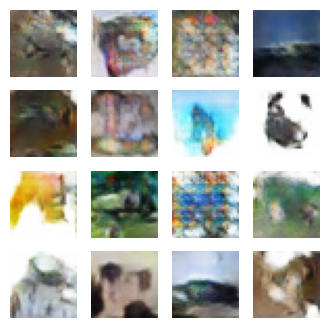

Epoch 50 completed


In [18]:
# Запуск обучения на наборе данных CIFAR-100
train(train_dataset, EPOCHS)



In [19]:
def generate_images(model, num_images=1):
    # Генерируем случайный шум
    noise = tf.random.normal([num_images, NOISE_DIM])
    
    # Создаем изображения с использованием генератора
    generated_images = model(noise, training=False)
    
    # Преобразуем изображения из диапазона [-1, 1] обратно в [0, 255]
    generated_images = (generated_images * 127.5 + 127.5).numpy().astype('uint8')
    
    # Отображаем изображения
    fig = plt.figure(figsize=(num_images, 1))
    
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(generated_images[i])
        plt.axis('off')
    
    plt.show()


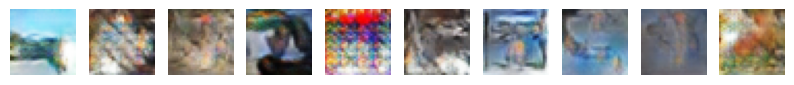

In [29]:
generate_images(generator, num_images=10)